$$
f(x) = \sin(x) \cdot \cos(x)
$$

$$
f(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{(x - \mu)^2}{2 \sigma^2}}
$$

In [86]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 适用于 Windows
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

def target_function(x):
    return np.exp(x)

def gaussian_function(x, mean=0, stddev=1):
    if stddev <= 0:
        raise ValueError("标准差 (stddev) 必须大于 0")
    return (1 / (stddev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / stddev) ** 2)

def generate_data(func, x_min=-10, x_max=10, num_points=100, test_ratio=0.2, normalize=True):
    """生成训练和测试数据"""
    x = np.linspace(x_min, x_max, num_points).reshape(-1, 1)
    x_min, x_max = np.min(x), np.max(x)
    y = func(x)
    
    return x, y, x_min, x_max

def normalize_input(x, x_min, x_max):
    """将输入归一化"""
    return (x - x_min) / (x_max - x_min) if x_min is not None and x_max is not None else x

# 生成数据
x, y, x_min, x_max = generate_data(target_function, x_min=-1, x_max=1, num_points=500)


# 两层 ReLU 网络的反向传播

## **1. 记号定义**
设：
- **输入层**：$ x \in \mathbb{R}^{N \times d} $，$ d $ 是输入维度，$ N $ 是批量大小。
- **第一层（隐藏层）**：
  - **权重矩阵**：$ W_1 \in \mathbb{R}^{d \times h} $，偏置 $ b_1 \in \mathbb{R}^{1 \times h} $。
  - **激活前输出**：  
    $$
    Z_1 = X W_1 + b_1
    $$
  - **ReLU 激活后输出**：
    $$
    A_1 = \max(0, Z_1)
    $$
- **输出层（无激活）**：
  - **权重矩阵**：$ W_2 \in \mathbb{R}^{h \times o} $，偏置 $ b_2 \in \mathbb{R}^{1 \times o} $。
  - **最终输出（logits）**：
    $$
    Z_2 = A_1 W_2 + b_2
    $$

- **损失函数**：均方误差（MSE）
  $$
  L = \frac{1}{N} \sum_{i=1}^{N} (Z_2 - Y)^2
  $$

---

## **2. 反向传播公式**
### **（1）损失对输出层的梯度**
$$
\frac{\partial L}{\partial Z_2} = \frac{2}{N} (Z_2 - Y)
$$

### **（2）输出层对权重的梯度**
$$
\frac{\partial L}{\partial W_2} = A_1^T \cdot \frac{\partial L}{\partial Z_2}
$$
$$
\frac{\partial L}{\partial b_2} = \sum_{i=1}^{N} \frac{\partial L}{\partial Z_2}
$$

### **（3）反传到隐藏层**
$$
\frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_2} \cdot W_2^T
$$

$$
\frac{\partial L}{\partial Z_1} = \frac{\partial L}{\partial A_1} \odot \text{ReLU}'(Z_1)
$$

其中，ReLU 的导数：
$$
\text{ReLU}'(Z_1) = 
\begin{cases} 
1, & Z_1 > 0 \\ 
0, & Z_1 \leq 0
\end{cases}
$$

### **（4）隐藏层对权重的梯度**
$$
\frac{\partial L}{\partial W_1} = X^T \cdot \frac{\partial L}{\partial Z_1}
$$
$$
\frac{\partial L}{\partial b_1} = \sum_{i=1}^{N} \frac{\partial L}{\partial Z_1}
$$


In [87]:
class ReLUNetwork:
    def __init__(self, input_dim=1, hidden_dim=128, output_dim=1, learning_rate=0.01):
        self.learning_rate = learning_rate

        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.1
        self.b1 = np.zeros((1, hidden_dim))

        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.1
        self.b2 = np.zeros((1, output_dim))

    @staticmethod
    def relu(x):
        """ReLU 激活函数"""
        return np.maximum(0, x)
    
    @staticmethod
    def relu_derivative(x):
        """ReLU 的导数"""
        return (x > 0).astype(float)
    
    def compute_loss(self, pred_y, true_y):
        """计算均方误差"""
        return np.mean((pred_y - true_y) ** 2)

    def forward(self, x):
        """前向传播"""
        self.z1 = np.dot(x, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        return self.z2  # 线性输出（无激活）
    
    def backward(self, x, pred_y, true_y):
        """反向传播"""
        batch_size = true_y.shape[0]
        
        # 输出层梯度
        dL_dz2 = 2 * (pred_y - true_y) / batch_size
        dL_dW2 = np.dot(self.a1.T, dL_dz2)
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)

        # 传播到隐藏层
        dL_da1 = np.dot(dL_dz2, self.W2.T)
        dL_dz1 = dL_da1 * self.relu_derivative(self.z1)
        dL_dW1 = np.dot(x.T, dL_dz1)
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)

        # 更新参数
        self.W1 -= self.learning_rate * dL_dW1
        self.b1 -= self.learning_rate * dL_db1
        self.W2 -= self.learning_rate * dL_dW2
        self.b2 -= self.learning_rate * dL_db2

    def train(self, train_x, train_y, epochs=10000):
        for epoch in range(epochs):
            pred_y = self.forward(train_x)  # 前向传播
            loss = self.compute_loss(pred_y, train_y)  # 计算损失
            self.backward(train_x, pred_y, train_y)  # 反向传播
            
            # 每 500 轮打印一次损失
            if epoch % 500 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.6f}")

    def predict(self, x):
        return self.forward(x)

Epoch 0, Loss: 1.988349
Epoch 500, Loss: 0.030027
Epoch 1000, Loss: 0.022052
Epoch 1500, Loss: 0.014538
Epoch 2000, Loss: 0.009566
Epoch 2500, Loss: 0.006849
Epoch 3000, Loss: 0.005096
Epoch 3500, Loss: 0.003829
Epoch 4000, Loss: 0.002975
Epoch 4500, Loss: 0.002424
Epoch 5000, Loss: 0.002053
Epoch 5500, Loss: 0.001788
Epoch 6000, Loss: 0.001587
Epoch 6500, Loss: 0.001426
Epoch 7000, Loss: 0.001294
Epoch 7500, Loss: 0.001183
Epoch 8000, Loss: 0.001088
Epoch 8500, Loss: 0.001006
Epoch 9000, Loss: 0.000934
Epoch 9500, Loss: 0.000870


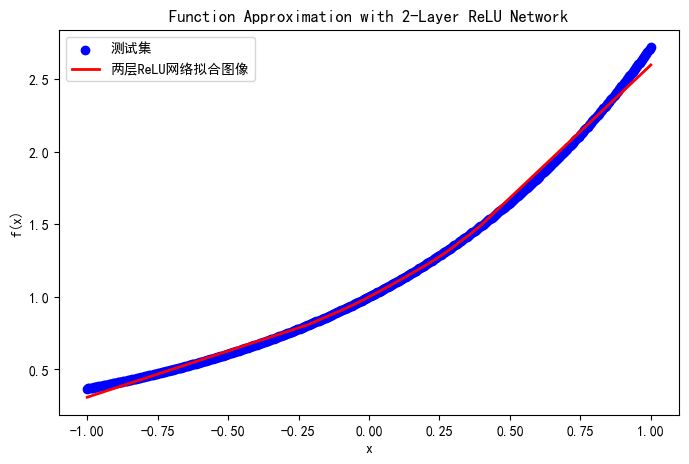

In [88]:
# 初始化模型
model = ReLUNetwork(input_dim=1, hidden_dim=256, output_dim=1, learning_rate=0.01)

# 训练模型
x_normalized = normalize_input(x, x_min, x_max)
model.train(x_normalized, y)
pred_test_y = model.predict(x_normalized)

# 画图对比
plt.figure(figsize=(8, 5))
plt.scatter(x, y, label="测试集", color="blue")
plt.plot(x, pred_test_y, label="两层ReLU网络拟合图像", color="red", linewidth=2)
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Function Approximation with 2-Layer ReLU Network")
plt.show()